In [1]:
import itertools
import math
import os
import gsd.hoomd
import hoomd
import numpy as np 
import warnings
import fresnel
import IPython
import packaging.version 
import matplotlib
import io 
import PIL
import freud
import matplotlib.pyplot as plt 

%matplotlib inline 
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [6]:
device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

def render(snapshot):

    vertices = [
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)

    geometry = fresnel.geometry.Polygon(
        scene, vertices = vertices, N=len(snapshot.particles.position)
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([100 / 255, 216 / 255, 230 / 255]), roughness=0.2
    )
    positions = np.array(snapshot.particles.position)[:, :2]
    geometry.position[:] = positions

    orientations = np.array(snapshot.particles.orientation)
    angles = 2 * np.arctan2(orientations[:, 3], orientations[:, 0])
    geometry.angle[:] = angles
    
    geometry.outline_width = 0.01

    fresnel.geometry.Box(scene, [L, L, 0.1, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(0, 0, 10), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [13]:
cpu = hoomd.device.CPU()

In [14]:
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='tile_lattice.gsd')

In [15]:
fn = os.path.join(os.getcwd(), 'trajectory_expansion_v1.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_expansion_v1.gsd', trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [11]:
mc = hoomd.hpmc.integrate.ConvexSpheropolyhedronUnion(default_d=0.1, default_a=0.1)

mc.shape["Hat_Tile"] = {
    "shapes": [
        {"vertices": [[-0.07407407407407407, 0.11025641025641017, 0.0], [-0.18518518518518517, -0.05512820512820507, 0.0], [0.25925925925925924, -0.05512820512820507, 0.0]], "sweep_radius": 0},
        {"vertices": [[-0.22222222222222215, -0.0012820512820512359, 0.0], [0.11111111111111116, -0.16666666666666669, 0.0], [0.11111111111111116, 0.16794871794871796, 0.0]], "sweep_radius": 0.02},
        {"vertices": [[0.14814814814814808, 0.11153846153846153, 0.0], [-0.07407407407407413, 0.11153846153846153, 0.0], [-0.07407407407407413, -0.22307692307692312, 0.0]], "sweep_radius": 0.02},
        {"vertices": [[0.037037037037037035, 0.1666666666666667, 0.0], [-0.18518518518518517, -0.16794871794871793, 0.0], [0.14814814814814814, 0.0012820512820512497, 0.0]], "sweep_radius": 0.02},
        {"vertices": [[-0.18518518518518517, 0.16794871794871796, 0.0], [-0.18518518518518517, -0.16666666666666669, 0.0], [0.37037037037037035, -0.0012820512820512359, 0.0]], "sweep_radius": 0.02},
        {"vertices": [[-0.14814814814814814, -0.11153846153846153, 0.0], [0.07407407407407407, -0.11153846153846153, 0.0], [0.07407407407407407, 0.22307692307692312, 0.0]], "sweep_radius": 0.02},
        {"vertices": [[0.25925925925925924, 0.1653846153846154, 0.0], [-0.2962962962962963, -6.938893903907228e-17, 0.0], [0.037037037037037035, -0.1653846153846153, 0.0]], "sweep_radius": 0.02},
        {"vertices": [[-0.18518518518518517, 0.1666666666666667, 0.0], [0.037037037037037035, -0.16794871794871793, 0.0], [0.1481481481481482, 0.0012820512820512497, 0.0]], "sweep_radius": 0.02},
        {"vertices": [[0.037037037037037035, 0.1666666666666667, 0.0], [-0.2962962962962963, 0.0012820512820512497, 0.0], [0.25925925925925924, -0.16794871794871793, 0.0]], "sweep_radius": 0.02},
        {"vertices": [[0.037037037037037035, 0.1653846153846154, 0.0], [-0.18518518518518517, -0.1653846153846153, 0.0], [0.1481481481481482, -6.938893903907228e-17, 0.0]], "sweep_radius": 0.02},
        {"vertices": [[0.2222222222222222, 0.11153846153846153, 0.0], [-0.2222222222222222, 0.11153846153846153, 0.0], [0.0, -0.22307692307692312, 0.0]]}
    ],
    "positions": [
        (-0.08831909, -0.20019724, 0), 
        (-0.27350427, 0.07672584, 0),
        (-0.42165242, 0.29852071, 0),
        (-0.31054131, 0.2433925, 0),
        (0.02279202, 0.07672584, 0),
        (0.0968661, -0.47840237, 0),
        (0.13390313, -0.08994083, 0),
        (0.35612536, 0.2433925, 0),
        (0.13390313, 0.2433925, 0),
        (0.35612536, -0.08994083, 0),
        (-0.05128205, -0.36686391, 0)
    ],
    "orientations": [(1, 0, 0, 0)] * 11,
    "overlap": [0] * 11  # No overlap adjustment for now
}

simulation.operations.integrator = mc

simulation.run(1)

gsd_writer.flush()

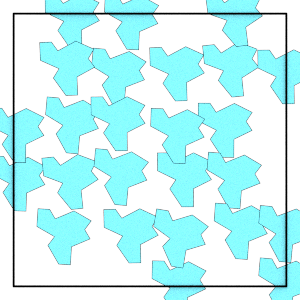

In [17]:
render(simulation.state.get_snapshot())

In [ ]:
Shape_1: # 1,2,11,12,13
(0.1709401709401709,-0.5899408284023668), 
(0.1709401709401709,-0.2553254437869822),
(-0.16239316239316243,-0.08994082840236695),
(-0.27350427350427353,-0.2553254437869822),
(-0.05128205128205132,-0.5899408284023668)

Shape_2: # 2,3,4,7,11

(0.1709401709401709,-0.2553254437869822),
(0.5042735042735043,-0.08994082840236695),
(0.3931623931623931,0.07544378698224852),
(-0.16239316239316243,0.2446745562130177),
(-0.16239316239316243,-0.08994082840236695)

Shape_3: # 4, 5, 6, 7

(0.3931623931623931,0.07544378698224852),
(0.5042735042735043,0.2446745562130177),
(0.1709401709401709,0.41005917159763317),
(-0.16239316239316243,0.2446745562130177)

Shape_4: # 7,8,9,10,11

(-0.16239316239316243,0.2446745562130177),
(-0.27350427350427353,0.41005917159763317),
(-0.49572649572649574,0.41005917159763317),
(-0.49572649572649574,0.07544378698224852),
(-0.16239316239316243,-0.08994082840236695)